## Learning the committor
Reference papers: 
- _Devergne, Kostic, Pontil, Parrinello, [J. Chem. Phys.](https://doi.org/10.1063/5.0246248) (2025), [ArXiv](https://chemrxiv.org/engage/chemrxiv/article-details/672cd8425a82cea2fa640adc)_

For a more practical example, see also the more advanced tutorial on training the infinitesimal generator for alanine dipeptide in the examples notebooks.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_infinitesimal_generator.ipynb)


## Introduction

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

### Load data

In [2]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

################################### SET THINGS HERE ###################################
# TODO change data eventually
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/B/COLVAR'
            ]
# TODO change data eventually
load_args = [{'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
            ]                     

# #######################################################################################

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels=True,
                                               filter_args={'regex': 'p.x|p.y'}, # to load many positions --> 'regex': 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'
                                               return_dataframe=True,
                                               load_args=load_args,
                                               verbose=True)
# TODO change data eventually
bias = torch.Tensor(dataframe['opes.bias'].values + dataframe['bias'].values)

dataset = compute_committor_weights(dataset, bias, [0, 1], beta=1) # it's muller

# create datamodule with only training set
datamodule = DictModule(dataset, lengths=[1])


Class 0 dataframe shape:  (9000, 24)
Class 1 dataframe shape:  (9000, 24)

 - Loaded dataframe (18000, 24): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'z.node-0', 'z.bias-0', 'q', 'bias', '@8.bias', '@8.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (18000, 2): ['p.x', 'p.y']


### Visualize training set

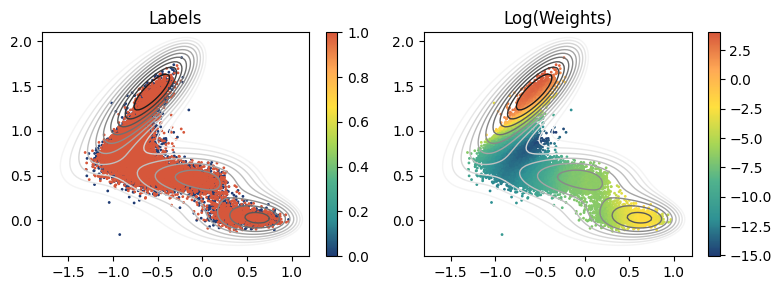

In [3]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')

plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=dataset['labels'], s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=torch.log(dataset['weights']), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

## Initialize infinitesimal generator model and training variables

### Initialize model

In [4]:
from mlcolvar.cvs.generator import Generator

# initialize variables
kBT = 1
masses = torch.Tensor([1.0])
n_atoms = 1
gamma = 10

# get friction
friction = kBT / (gamma*masses)
print(friction)

options = { 'nn':{'activation':'tanh'},
            'optimizer' : {'lr': 5e-4, 'weight_decay': 1e-5}}

model = Generator(r=3,
                  layers=[2,20,20,1],
                  eta=0.05,
                  alpha=0.01,
                  friction=friction,
                  n_dim=2,
                  options=options)

tensor([0.1000])


In [ ]:
# define callbacks
from mlcolvar.utils.trainer import MetricsCallback

metrics = MetricsCallback()

 # small number of epochs for testing, use 15/20k
trainer = lightning.Trainer(callbacks=[metrics],
                            max_epochs=5, 
                            num_sanity_val_steps=0,
                            limit_val_batches=0,
                            enable_checkpointing=False,
                            enable_progress_bar = True, #disable progress bar because it made everything bug on my workstation
                            logger=None
                            )
# fit model
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | GeneratorLoss | 3      | ?        | ?        
1 | nn      | ModuleList    | 1.5 K  | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15000` reached.


### Plot metrics

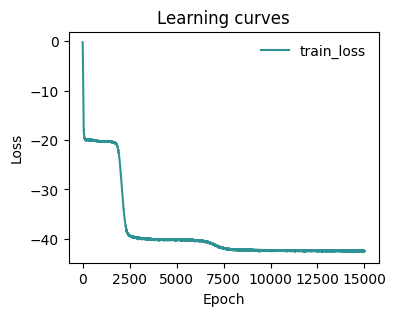

In [6]:
from mlcolvar.utils.plot import plot_metrics, paletteFessa, paletteCortina

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss'],
                  colors=['fessa1', 'fessa3', 'fessa4', 'fessa5'],
                  ax = ax)

## Compute eigenfunctions

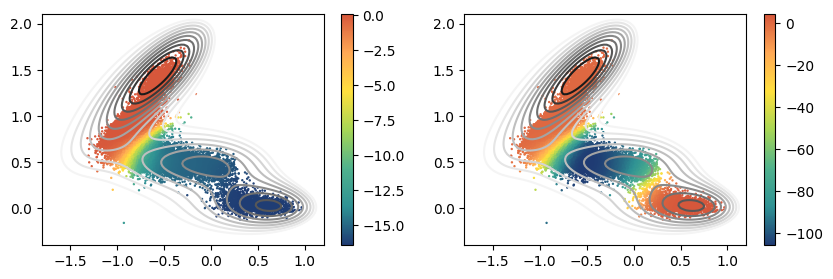

In [7]:
# compute the eigenfunctions for each point in the dataset
    # the parameters of compute_eigenfunctions are already stored in the model.
    # if you want to change them, you can pass them as args (see docstring)
eigenfunctions, evals, evecs = model.compute_eigenfunctions(dataset, friction=friction)

# vsiualize them
fig, axs = plt.subplots(ncols=2,figsize=(10,3))
for i in range(1,3):
    cp = axs[i-1].scatter(dataframe["p.x"], dataframe["p.y"], c=eigenfunctions[:,i].detach(), s=0.5, cmap='fessa')
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=axs[i-1])
    plt.colorbar(cp, ax=axs[i-1])


## Forecast state occupation

### Classify points in the dataset

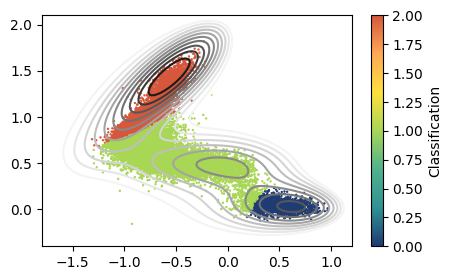

In [8]:
# this helper function helps classifying the states based on the sign of the eigenfunctions, more refined criteria can also be used
def classify_points(array):
    # Initialize classification to 10
    classification = np.ones(array.shape[0], dtype=int) * 10
    
    # Create masks for each condition
    mask_0 = ((array[:, 2] > 0.0) & (array[:, 1] < 0) ) 
    mask_1 = ((array[:, 2] < 0.0) )  
    mask_2 = (array[:, 1] > 0.0)  
    
    # Assign classifications based on conditions
    classification[mask_0] = 0
    classification[mask_1] = 1
    classification[mask_2] = 2

    # Return classification labels (replace numerical classifications)
    return classification

classification = classify_points(eigenfunctions)

fig, axs = plt.subplots(ncols=1,figsize=(5,3))
cp = axs.scatter(dataframe["p.x"], dataframe["p.y"], c=classification, s=0.5, cmap='fessa')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=axs)
plt.colorbar(cp, label='Classification')
plt.show()

###  Compute occupation over time

In [9]:
from mlcolvar.cvs.generator.utils import forecast_state_occupation

start = 0.01  # A small positive number to avoid log(0)
end = 1000000
num_points = 100  # Adjust the number of points as needed

# the evolution is exponential, so we use a logarithmic scale
times = torch.logspace(np.log10(start), np.log10(end), num_points)

occupations = forecast_state_occupation(eigenfunctions, 
                              evals,
                              times, 
                              torch.Tensor(classification),
                              dataset["weights"], 
                              3)

### Plot occupation over time for the different states

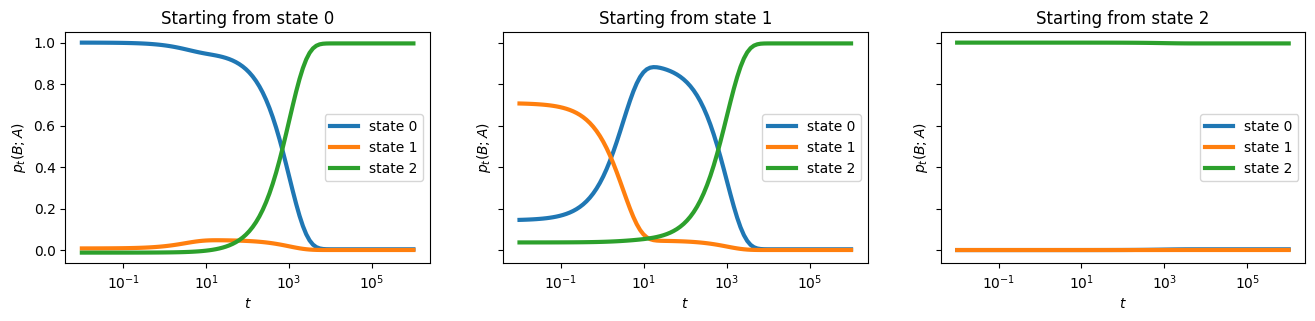

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(16,3), sharey=True)
initial_state = 0
for initial_state in range(0,3):
    for final_state in range(0,3):
        ax = axs[initial_state]
        ax.plot(times.cpu().detach(), occupations[initial_state,final_state].cpu().detach(),linewidth=3,label=f"state {final_state}")
        #ax.plot(times.cpu().detach(), occupations2[initial_state,final_state].cpu().detach(),linewidth=3,label=f"state {final_state}")
        ax.set_xscale("log")
        ax.set_title(f"Starting from state {initial_state}")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$p_t(B;A)$")
    ax.legend()
plt.show()


## Export model with tracing

In [ ]:
traced_model = model.to_torchscript(file_path='test_trace.pt', method='trace')